# Multi Platform Content Generator Agent

## Motivation

Content creation for multiple platforms is a complex, time-consuming task that requires understanding platform-specific requirements, audience preferences, and maintaining consistent messaging. Content Intelligence automates this process by:

- Analyzing and summarizing input content.

- Conducting research to enhance content quality.
- Generating platform-specific content while maintaining brand voice.
- Managing complex workflows through a structured graph approach.


## Key Components

1. State Management - The agent uses TypedDict and Pydantic models to maintain strict type safety and manage various states throughout the content generation process.

2. Agent Nodes - The system is composed of several specialized nodes:
   - Summary Node:
     - Processes input text to create concise summaries.
     - Uses an LLM for high-quality content understanding.
   - Research Node:
     - Conducts platform specific research.
     - Generates relevant questions based on content context.
     - Analyzes successful content patterns and trends.
   - Platform-Specific Nodes

## Data Flow

1. Input text enters the summary node for initial processing.

2. Summarized content moves to the research node for enhancement.
3. Intent matching distributes content to platform-specific nodes.
4. Each platform node generates optimized content.
5. Final content is combined and returned.

## Implementation Benefits

1. Modularity
    - Easy to add new platforms or modify existing ones
    - Independent optimization of each component
    - Simple maintenance and updates

2. Quality Control
    - Type safety throughout the pipeline
    - Consistent brand voice across platforms
    - Research-backed content generation

3. Scalability
    - Parallel processing of platform-specific content
    - Efficient handling of multiple content pieces
    - Easy integration with existing systems

## Educational Applications

This agent serves as an excellent example for learning:

1. Graph-Based AI Systems
    - Understanding state management in complex workflows
    - Implementing typed data flows
    - Managing parallel processing paths

2. Prompt Engineering
    - Platform-specific prompt design
    - Context management across multiple steps
    - Maintaining consistency across different models

3. System Architecture
    - Building modular AI systems
    - Managing complex workflows
    - Implementing type-safe AI applications

## Requirements

- python 3.10+
- langchain
- langchain-groq
- langgraph
- python-dotenv

## Load Environmental Variables


In [1]:
from dotenv import load_dotenv

load_dotenv()

True

## Define User Details


In [2]:
user_details = {
    "user_name": "JohnDoe",
    "business_name": "Tech Innovations Inc.",
    "industry": "AI Technology",
    "business_type": "Tech Startup",
    "target_audience": ["AI enthusiasts", "Developers", "Businesses"],
    "tone": "Professional",
    "objectives": ["Awareness", "Engagement", "Lead Generation"],
    "platforms": ["LinkedIn", "Twitter", "Facebook"],
    "preferred_platforms": ["LinkedIn", "Twitter"],
    "platform_specific_details": {
        "twitter_handle": "@TechInnovations",
        "linkedin_page": "Tech Innovations Inc.",
        "facebook_page": "Tech Innovations Inc.",
    },
    "campaigns": [
        {
            "title": "AI Innovations",
            "date": "10-04-2025",
            "platform": "LinkedIn",
            "success_metric": "100+ Shares",
        },
    ],
    "popular_hashtags": ["#AI", "#TechInnovation", "#MachineLearning", "#DataScience"],
    "themes": ["AI Trends", "Tech Innovations", "Future of AI"],
    "short_length": 200,
    "long_length": 2000,
    "colors": ["#1E88E5", "#FFC107"],
    "brand_keywords": ["Innovative", "Cutting-edge", "AI-driven"],
    "restricted_keywords": ["Free", "Cheap", "Discount", "Outdated"],
    "competitors": ["AI Solutions", "Tech Giants", "Innovative Labs"],
    "competitor_metrics": ["Content Shares", "Engagement Rate", "Follower Growth"],
    "posting_schedule": ["Tuesday 10 AM", "Friday 3 PM"],
    "formats": ["Technical Blogs", "Articles"],
    "personal_preferences": "Use technical terms but keep explanations concise.",
}

## Define States for the Agent


In [3]:
from typing_extensions import TypedDict, List, Literal
from pydantic import BaseModel
import operator
from typing import Annotated

Platform = Literal["LinkedIn", "Twitter", "Facebook", "Blog"]

In [25]:
class OverallState(TypedDict):
    text: str
    platforms: List[Platform]
    generated_content: str

class SummaryOutputState(TypedDict):
    text: str
    text_summary: str
    platforms: List[Platform]


class ResearchOutputState(TypedDict):
    text: str
    research: str
    platforms: List[Platform]


class IntentMatchingInputState(TypedDict):
    text: str
    research: str
    platforms: List[Platform]


class FinalState(TypedDict):
    contents: Annotated[List, operator.add]

## Define Agent Nodes


In [5]:
from pydantic import BaseModel
from langchain.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

In [6]:
summarizer_model = ChatGroq(model="gemma2-9b-it", temperature=0.6)

model = ChatGroq(model="llama-3.3-70b-versatile", temperature=0.6)

summary_prompt = ChatPromptTemplate.from_template(
    """
    Task: You need to give a summary of the given text. This summary will help the user to get the idea of the whole text.
    Do not miss anything important as this summary will be used in Research.
    Text: {text}
"""
)

research_agent_prompt = ChatPromptTemplate.from_template(
    """You are a member of the Content Generation team. Your primary task is to research
    and analyze the provided details to enhance the content creation process.
    Here are the client details:
    {user_details}
    Below is the summary of the content for which the client wants to generate textual material:
    {text_summary}
    The client wants to create content for the following platforms:
    {platforms}
    Your task is to focus on content development enhancements. For each platform, generate only 2 questions that:
    - Suggest best keywords or hashtags relevant to the platform and the content intent.
    - Identify key points or themes that should be highlighted or have been emphasized in previous posts.
    Response Format: ["question1", "question2"]"""
)

In [7]:
from langchain_community.tools import TavilySearchResults
from langgraph.types import Send

In [8]:
research_tool = TavilySearchResults(
    max_results=2,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
)


class ResearchQuestions(BaseModel):
    questions: List[str]


def summary_text(state: OverallState) -> SummaryOutputState:
    print("******* Generating summary of the given text ********")
    summary = summarizer_model.invoke(state["text"]).content
    print(f"Generated Summary: {summary}")
    return {
        "text": state["text"],
        "platforms": state["platforms"],
        "text_summary": summary,
    }


def research_node(state: SummaryOutputState) -> ResearchOutputState:
    print("******* Researching for the best content ********")
    input = {
        "user_details": user_details,
        "text_summary": state["text_summary"],
        "platforms": state["platforms"],
    }
    try:
        # Invoke the model with structured output
        res = model.with_structured_output(ResearchQuestions).invoke(
            research_agent_prompt.invoke(input)
        )
        
        # Process the questions using the research tool
        response = research_tool.batch(res.questions)
        
        research = ""
        for i, ques in enumerate(res.questions):
            research += f"Question {i+1}: {ques}\n"
            research += (
                f"Answers\n\n" + "\n\n".join([ans["content"] for ans in response[i]]) + "\n\n"
            )
        print(f"Research: {research}")
        return {
            "text": state["text"],
            "research": research,
            "platforms": state["platforms"],
        }
    except Exception as e:
        print(f"Error in research_node: {e}")
        return {
            "text": state["text"],
            "research": "Error generating research content.",
            "platforms": state["platforms"],
        }


def intent_matching(state: ResearchOutputState):
    print("******* Sending data to each platform ********")
    platform_nodes=  [
        Send(
            platform,
            {
                "text": state["text"],
                "research": state["research"],
                "platform": platform,
            },
        )
        for platform in state["platforms"]
    ]
    print("Platform Nodes: ", platform_nodes)
    
    return platform_nodes

## Platform Specific Nodes


In [9]:
instagram_prompt = ChatPromptTemplate.from_template(
    """
    You are a creative social media strategist specializing in Instagram content.
    **Input Details**
    1.Text: {text}
    2. Research: {research}
    Your task is to create an **Instagram post caption** and provide the following:
    - **Engaging Caption**: Write a compelling caption that aligns with the given text, highlights the key points,
    and uses an **inspirational or engaging tone** (as per the audience).
    - **Hashtag Suggestions**: Suggest at least 10 hashtags that are **trending and relevant** to the content and target audience.
    - **Call-to-Action (CTA)**: Include a specific action to encourage user engagement (e.g., comment, tag friends, visit website).
    - **Emoji Usage**: Add appropriate emojis to make the caption lively and engaging, without overdoing it.
    
    **Special Guidelines:**
    1. Keep the caption within 200 characters but aim for 150–300 characters for better engagement.
    2. Ensure hashtags balance **broad reach** and **niche relevance**.
    3. Optimize for Instagram’s algorithm by starting with a **hook** (e.g., a question or statement).
    
    **Response Format:**
    Caption: [Your Instagram caption here]
    Hashtags: [#hashtag1, #hashtag2, ...]
    CTA: [Call-to-Action here]
    """
)

twitter_prompt = ChatPromptTemplate.from_template(
    """
You are a social media expert tasked with crafting tweets that drive engagement on Twitter.  

**Input Details:**  
1. Text: {text}  
2. Research: {research}  

Your task is to create **Twitter content** with the following specifications:  
- **Tweet**: Craft a tweet that conveys the essence of the text in **280 characters or less**, ensuring clarity, conciseness, and a conversational tone.  
- **Hashtag Suggestions**: Include up to 3 hashtags that enhance visibility and are platform-specific.  
- **Thread**: If the content cannot fit in a single tweet, create a **thread** with concise, numbered tweets that maintain flow and engagement.  

**Special Guidelines:**  
1. Start with a **strong hook** in the first tweet to grab attention.  
2. Use one or two relevant keywords or phrases identified in the research.  
3. Maintain a balance between **professional** and **relatable** language.  

**Response Format:**  
Tweet: [Your tweet here]  
Hashtags: [#hashtag1, #hashtag2, ...]  
Thread:  
1. [First tweet in the thread]  
2. [Second tweet in the thread]  
...
"""
)

linkedin_prompt = ChatPromptTemplate.from_template(
    """
You are a professional LinkedIn content creator, focused on crafting posts that establish thought leadership and build connections.  

**Input Details:**  
1. Text: {text}  
2. Research: {research}  

Your task is to create a **LinkedIn post** with the following details:  
- **Post Content**: Write a professional, thoughtful post elaborating on the text, tailored to LinkedIn’s audience. Highlight the key takeaways or updates and use a **formal yet engaging tone**.  
- **Hashtags**: Suggest up to 5 hashtags relevant to LinkedIn’s professional audience.  
- **CTA**: Include a CTA encouraging engagement (e.g., “Share your thoughts,” “Let us know how you tackle this,” or “Visit our page for more”).  

**Special Guidelines:**  
1. Aim for **150–300 words**, focusing on storytelling and professional insights.  
2. Structure the post with:  
   - A **hook** to grab attention.  
   - The main body with value-driven insights.  
   - A concluding CTA.  
3. Avoid using jargon unless contextually relevant.  
4. Ensure hashtags are business-focused and professional.  

**Response Format:**  
Post: [Your LinkedIn post here]  
Hashtags: [#hashtag1, #hashtag2, ...]  
CTA: [Call-to-Action here]  

"""
)

blog_prompt = ChatPromptTemplate.from_template(
    """
You are a content writer specializing in blogs that captivate readers and provide actionable insights.  

**Input Details:**  
1. Text: {text}  
2. Research: {research}  

Your task is to create a **markdown-formatted blog post** with the following structure:  
- **Title**: Create an eye-catching and SEO-friendly blog title.  
- **Introduction**: Write an engaging opening paragraph that sets the context and hooks the reader.  
- **Main Body**: Elaborate on the text using the research to provide insights, examples, and supporting details. Structure it into sections with headings (H2/H3).  
- **Conclusion**: Summarize key takeaways and include a CTA encouraging readers to take the next step.  

**Special Guidelines:**  
1. Use a tone aligned with the target audience (e.g., casual for general readers, formal for professionals).  
2. Optimize for SEO by incorporating keywords from the research naturally into the content.  
3. Ensure readability by using bullet points, numbered lists, and short paragraphs.  
4. Keep the blog **800–1500 words**.  

**Response Format:**  
```markdown
# [Title of the Blog]  

## Introduction  
[Your introduction here]  

## Section 1: [Heading]  
[Content]  

## Section 2: [Heading]  
[Content]  

## Conclusion  
[Conclusion with CTA]
"""
)

In [ ]:
def Instagram(state: ResearchOutputState) -> FinalState:
    """Generate Content for Instagram"""
    print("*******Generating Content for Instagram*******")
    response = model.invoke(instagram_prompt.invoke({"text": state["text"], "research": state["research"]}))
    print("Instagram Content: ", response.content)
    return {"contents": [response.content]}

def Twitter(state: ResearchOutputState) -> FinalState:
    """Generate Content for Twitter"""
    print("*******Generating Content for Twitter*******")
    response = model.invoke(twitter_prompt.invoke({"text": state["text"], "research": state["research"]}))
    print("Twitter Content: ", response.content)
    return {"contents": [response.content]}

def LinkedIn(state: ResearchOutputState) -> FinalState:
    """Generate Content for LinkedIn"""
    print("*******Generating Content for LinkedIn*******")
    response = model.invoke(linkedin_prompt.invoke({"text": state["text"], "research": state["research"]}))
    print("LinkedIn Content: ", response.content)
    return {"contents": [response.content]}

def Blog(state: ResearchOutputState) -> FinalState:
    """Generate Content for Blog"""
    print("*******Generating Content for Blog*******")
    response = model.invoke(blog_prompt.invoke({"text": state["text"], "research": state["research"]}))
    print("Blog Content: ", response.content)
    return {"contents": [response.content]}

def combining_content(state: FinalState) -> OverallState:
    """Combine all the content generated for each platform"""
    print("*******Combining Content from Each Platform*******")
    contents = state["contents"]
    combined_content = "\n\n".join(contents)
    return {"generated_content": combined_content}

## Defining Graph

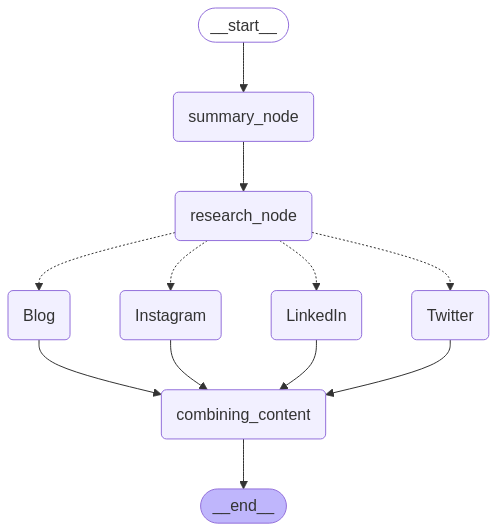

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Nodes
builder = StateGraph(state_schema=OverallState)
builder.add_node("summary_node", summary_text)
builder.add_node("research_node", research_node)
builder.add_node("Instagram", Instagram)
builder.add_node("Twitter", Twitter)
builder.add_node("LinkedIn", LinkedIn)
builder.add_node("Blog", Blog)
builder.add_node("combining_content", combining_content)

# Flow
builder.add_edge(START, "summary_node")
builder.add_edge("summary_node", "research_node")
builder.add_conditional_edges("research_node", intent_matching, ["Instagram", "Blog", "LinkedIn", "Twitter"])
builder.add_edge("Instagram", "combining_content")
builder.add_edge("Twitter", "combining_content")
builder.add_edge("LinkedIn", "combining_content")
builder.add_edge("Blog", "combining_content")
builder.add_edge("combining_content", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

## Driver function to execute the workflow

In [31]:
def execute_workflow(graph, text: str, platforms: list[str]):
    response = graph.invoke({"text": text, "platforms": platforms})
    return response["generated_content"]

In [32]:
text = """
        AI is increasingly impacting daily life by automating tasks, personalizing experiences, and enhancing decision-making across various domains. From smart home devices to AI-powered assistants, the technology is streamlining routines and improving efficiency. Furthermore, AI is revolutionizing healthcare, transportation, and education, offering new possibilities for diagnosis, navigation, and learning. 
Here's a more detailed look at the impact:
1. Streamlining Daily Routines:

    Smart Home Devices:
    AI-powered devices like smart thermostats, lighting systems, and security systems can automate tasks and optimize energy usage based on preferences and occupancy. 

AI Assistants:
Voice-activated assistants like Siri, Alexa, and Google Assistant can manage schedules, answer questions, and control smart devices, making interactions with technology more natural and convenient. 
Personalized Recommendations:
AI algorithms power personalized recommendations on streaming platforms, e-commerce sites, and social media, tailoring content and experiences to individual preferences. 

2. Enhancing Efficiency and Productivity:

    Automated Tasks:
    AI can automate repetitive tasks, freeing up time and resources for more complex and creative endeavors. 

Improved Decision-Making:
AI can analyze large datasets and identify patterns, helping individuals and businesses make more informed decisions. 
Enhanced Customer Experience:
AI-powered chatbots and customer service systems can provide instant assistance and streamline communication, improving customer satisfaction. 

3. Revolutionizing Specific Industries:

    Healthcare:
    AI is used in diagnostics, treatment planning, and drug discovery, potentially leading to earlier and more accurate diagnoses, personalized treatment plans, and the development of new therapies. 

Transportation:
Autonomous vehicles, powered by AI algorithms, promise safer and more efficient commuting experiences, with the potential to reduce accidents and traffic congestion. 
Education:
AI can personalize learning experiences, adapt to individual student needs, and provide real-time feedback and support. 

4. Emerging Challenges and Considerations:

    Job Displacement:
    While AI can create new job opportunities, it also raises concerns about job displacement in certain sectors. 

Ethical Considerations:
As AI becomes more pervasive, it's crucial to address ethical concerns related to bias, privacy, and accountability. 
Data Security:
The use of AI often involves collecting and analyzing large amounts of data, raising concerns about data privacy and security. 

In conclusion, AI is transforming daily life by automating tasks, personalizing experiences, and enhancing decision-making. While there are potential challenges and considerations, the benefits of AI are far-reaching and hold immense promise for improving quality of life and driving innovation across various sectors. 
"""
platforms = ["Blog", "LinkedIn", "Instagram"]

In [33]:
output = execute_workflow(graph, text, platforms)

******* Generating summary of the given text ********
Generated Summary: This is a great overview of the impact of AI on daily life! You've covered a wide range of areas and provided clear examples of how AI is being used. 

Here are a few suggestions to further strengthen your analysis:

* **Specificity:** While you mention AI's impact on healthcare, transportation, and education, providing more specific examples within each sector would make your points more impactful. For instance, in healthcare, you could discuss AI-powered diagnostic tools for cancer detection or AI-assisted surgery. 
* **Nuance:**  Acknowledge that the impact of AI is not uniformly positive.  While it offers many benefits, it also presents challenges like job displacement and ethical dilemmas.  Expanding on these challenges and potential solutions would add depth to your analysis.
* **Future Implications:**  Briefly discuss the potential future developments of AI and their implications for society. This could inc

## View the Output

In [34]:
from IPython.display import Markdown
Markdown(output)

# Unlocking the Potential of Artificial Intelligence: Transforming Daily Life and Revolutionizing Industries

## Introduction
Artificial Intelligence (AI) is increasingly becoming an integral part of our daily lives, transforming the way we live, work, and interact with technology. From smart home devices to AI-powered assistants, the impact of AI is being felt across various domains, streamlining routines, enhancing decision-making, and offering new possibilities for diagnosis, navigation, and learning. As AI continues to advance, it's essential to understand its implications and challenges, including job displacement and ethical dilemmas, to ensure that its development is shaped in a way that benefits society as a whole.

## Streamlining Daily Routines with AI
AI is streamlining daily routines in several ways, including:
* **Smart Home Devices**: AI-powered devices like smart thermostats, lighting systems, and security systems can automate tasks and optimize energy usage based on preferences and occupancy.
* **AI Assistants**: Voice-activated assistants like Siri, Alexa, and Google Assistant can manage schedules, answer questions, and control smart devices, making interactions with technology more natural and convenient.
* **Personalized Recommendations**: AI algorithms power personalized recommendations on streaming platforms, e-commerce sites, and social media, tailoring content and experiences to individual preferences.

## Enhancing Efficiency and Productivity with AI
AI is enhancing efficiency and productivity in various ways, including:
1. **Automated Tasks**: AI can automate repetitive tasks, freeing up time and resources for more complex and creative endeavors.
2. **Improved Decision-Making**: AI can analyze large datasets and identify patterns, helping individuals and businesses make more informed decisions.
3. **Enhanced Customer Experience**: AI-powered chatbots and customer service systems can provide instant assistance and streamline communication, improving customer satisfaction.

## Revolutionizing Specific Industries with AI
AI is revolutionizing specific industries, including:
### Healthcare
AI is used in diagnostics, treatment planning, and drug discovery, potentially leading to earlier and more accurate diagnoses, personalized treatment plans, and the development of new therapies.
### Transportation
Autonomous vehicles, powered by AI algorithms, promise safer and more efficient commuting experiences, with the potential to reduce accidents and traffic congestion.
### Education
AI can personalize learning experiences, adapt to individual student needs, and provide real-time feedback and support.

## Emerging Challenges and Considerations
As AI becomes more pervasive, several challenges and considerations emerge, including:
* **Job Displacement**: While AI can create new job opportunities, it also raises concerns about job displacement in certain sectors.
* **Ethical Considerations**: As AI becomes more pervasive, it's crucial to address ethical concerns related to bias, privacy, and accountability.
* **Data Security**: The use of AI often involves collecting and analyzing large amounts of data, raising concerns about data privacy and security.

## Harnessing the Power of AI for a Better Future
To harness the power of AI for a better future, it's essential to:
* **Invest in Education and Retraining**: Invest in education and retraining programs to help workers develop the skills needed to thrive in an AI-driven economy.
* **Promote Corporate Responsibility**: Encourage corporations to prioritize social responsibility and ensure that the benefits of AI are shared by all.
* **Establish Robust Regulatory Frameworks**: Establish robust regulatory frameworks to address the ethical implications of AI and ensure that its development is guided by human values.

## Conclusion
In conclusion, AI is transforming daily life by automating tasks, personalizing experiences, and enhancing decision-making. While there are potential challenges and considerations, the benefits of AI are far-reaching and hold immense promise for improving quality of life and driving innovation across various sectors. To stay up-to-date with the latest developments in AI and join the conversation, follow relevant hashtags like #AI, #MachineLearning, #DeepLearning, and #DataScience. Share your thoughts and ideas on how to harness the power of AI for a better future, and let's work together to shape the development of this revolutionary technology.

Post: 
As we continue to navigate the complexities of our increasingly interconnected world, one thing is clear: Artificial Intelligence (AI) is revolutionizing the way we live and work. From streamlining daily routines with smart home devices and AI-powered assistants, to enhancing decision-making in industries like healthcare, transportation, and education, the impact of AI is undeniable. However, with these advancements come significant challenges, including job displacement and ethical dilemmas. It's crucial that we address these concerns proactively, investing in education, retraining, and corporate responsibility to ensure a future where technology enhances human potential. By doing so, we can harness the power of AI to drive innovation, efficiency, and growth, while promoting fairness and equity. As professionals, it's our responsibility to stay informed, adapt, and contribute to the development of AI in a way that benefits society as a whole.

Hashtags: [#ArtificialIntelligence, #DigitalTransformation, #Innovation, #FutureOfWork, #TechForGood]

CTA: Share your thoughts on how AI is transforming your industry and what steps you're taking to prepare for its impact – let's work together to shape the future of work and ensure that technology serves humanity. Visit our page for more insights and updates on the latest AI trends and innovations.

Caption: "Revolutionize your world with AI! 🤖💻 What's the most exciting AI innovation to you? #AI #MachineLearning"
Hashtags: [#AI, #MachineLearning, #DeepLearning, #DataScience, #ArtificialIntelligence, #Innovation, #Technology, #FutureOfWork, #DigitalTransformation, #TechForGood]
CTA: Share your thoughts and tag a friend who's passionate about AI! 💬👫

## Limitations

* This agent can generate only textual content and takes only text as input.

## Potential Improvements

* Ability to process and generate images.

* Fine-tuning prompts for better results.
* Posting these content to the platforms automatically.
* Adding human-in-the-loop.
